## Info
Setting up the model to receate the hydrosynamics of the Solitary Wave model from BarSed.

Author: WaveHello

Date: 07/15/2024

### Notes
ADV data and pressure data for the solitary wave cases aren't in the folders I downloaded. I'm not sure where that data is or if it was recorded.

This code is from the wave_bc subroutine of xBeach. This requires
order = 2 <br>
lwave = 1 <br>
or the velocities are zeroed. There is other conditions in the code that use the order = 2 condtion or the velocities go to zero condition so in general make sure you use order = 2.

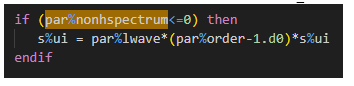

In [36]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
import pandas as pd
from scipy import special

# Set global constants
PI = np.pi
G = 9.81

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

In [37]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"..\..\..\BarSed_Lib")

# Import the library modules

from lib.data_classes.Run import Run
from lib.general_funcs.signal_processing import moving_average_filter
from lib.general_funcs.kinematic_funcs import calc_velocity
from lib.general_funcs.path_funcs import create_directory_if_not_exists


In [38]:
from xbTools.grid.creation import xgrid
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script


In [39]:
# Fuctions
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path



### Set the information for the selected Run

In [40]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"..\..\..\BarSed_Data"

# Set the information needed for specifying the run
# Run number
run_number = "017"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)


### Set data that isn't directly available in the inputs

### Get the bathymetry for the model

In [41]:
# Name of the bathy data binary
bathy_file_name = r"bathy.mat"

# Path to where I'm storing the bathymetry data
bathy_file_path = os.path.join(barsed_data_path, bathy_file_name)

print(f"Bathy file path: {bathy_file_path}")

Bathy file path: ..\..\..\BarSed_Data\bathy.mat


### Get the path to the wave gauge data

In [42]:

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the bathymetry data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

print(f"Run{run_number} wave mat file path: {wave_data_path}")

Run017 wave mat file path: ..\..\..\BarSed_Data\WG\RUN017.mat


### Get the path to the adv data
The period of the wave maker is stored in this data. Not using it for anything else at the momement.

In [43]:
# Name of the folder containing the adv data
ADV_data_folder_name = r"ADV"

# Path to where the velocity data is being stored
ADV_data_path = os.path.join(barsed_data_path, ADV_data_folder_name)

# Path to the adv data for the selected run
ADV_file_path = os.path.join(ADV_data_path, run_name)

print(f"{ADV_data_folder_name} file path: {ADV_data_path}")
print("{} Data for mat file path: {}".format(ADV_data_folder_name, ADV_file_path))

ADV file path: ..\..\..\BarSed_Data\ADV
ADV Data for mat file path: ..\..\..\BarSed_Data\ADV\RUN017.mat


### Collect the bathymetry data

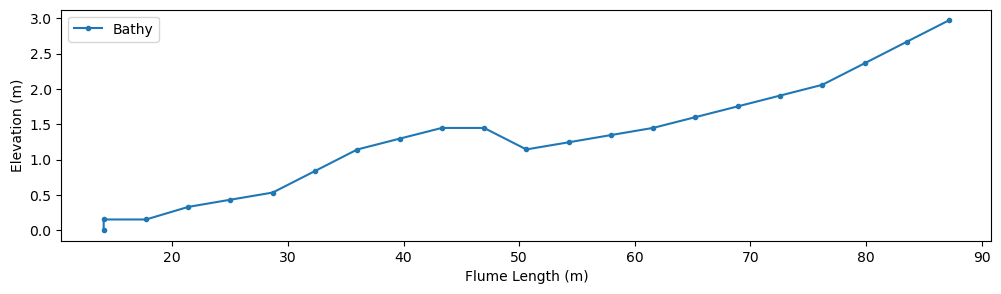

In [44]:
# Make a plot of the bathymetry to make sure the data is right
# Load the .mat file
bathy_dict = scipy.io.loadmat(bathy_file_path)

# Get the bathymetry data
bathy_df = pd.DataFrame(bathy_dict["bathy"], columns = ["x_loc", "z_loc"])

bathy_df.plot("x_loc", "z_loc", marker = ".", 
              figsize = (12, 3), label = "Bathy", 
              ylabel= "Elevation (m)", xlabel = "Flume Length (m)"
)

plt.legend()
plt.show()

In [45]:
bathy_df

,x_loc,z_loc
0,14.064,0.000
1,14.064,0.152
2,17.724,0.152
3,21.381,0.330
4,25.034,0.432
5,28.688,0.533
6,32.339,0.837
7,35.996,1.142
8,39.655,1.295
9,43.313,1.447


### Construct the Run object
This object will help organize the data and help store the data

In [46]:
Run_data = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = ADV_file_path)

print(Run_data)


id: RUN017
Start Date: None
Wave Data File path: ..\..\..\BarSed_Data\WG\RUN017.mat
Num pressure gagues: None
Num advs: None


### Collect the wave gauge data

New Number of 17 wave gauges
Wave Maker information:
Number of times: 13886


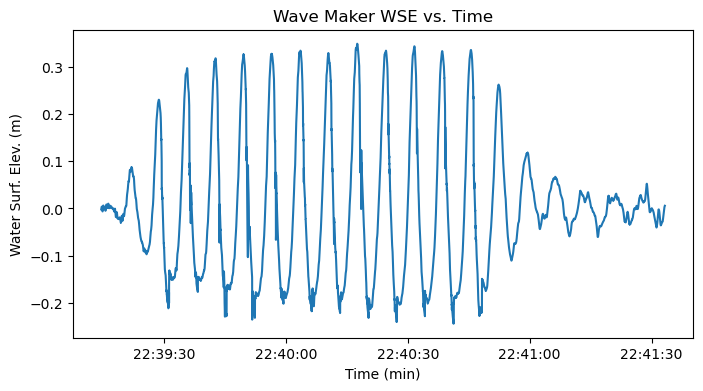

In [47]:
Run_data.load_wave_data()

print(Run_data.wave_maker)

Run_data.wave_maker.quick_wse_plot()

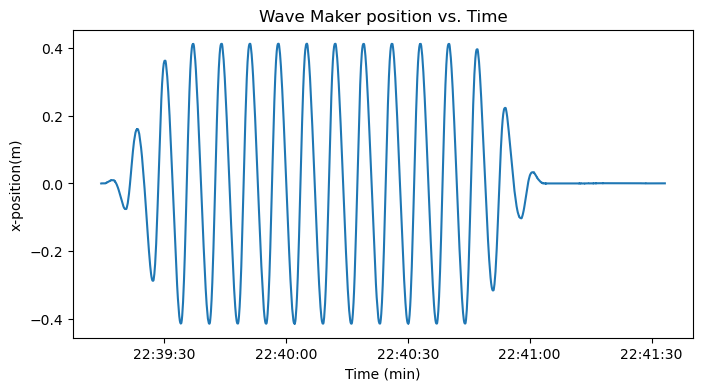

In [48]:
Run_data.wave_maker.quick_position_plot()

## Smoothing the surface data

In [49]:
# Convert the wave maker date_time to time in seconds
first_time = Run_data.wave_maker.date_time[0]

seconds_from_first = np.array([(dt - first_time).total_seconds() for dt in Run_data.wave_maker.date_time])


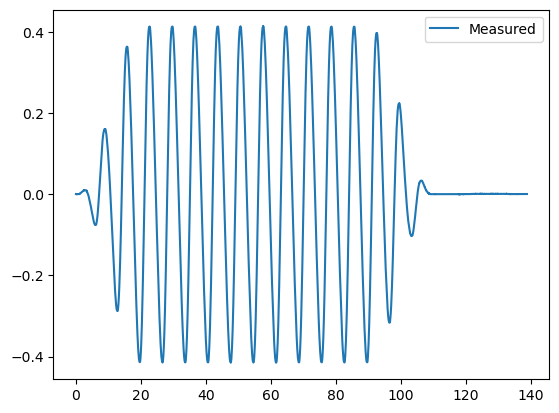

In [50]:
# Plot the wave maker location as a function of time in seconds

fig, axs = plt.subplots(nrows = 1, ncols = 1)

axs = np.atleast_1d(axs)

shift = 10
wave_maker_loc = Run_data.wave_maker.position
axs[0].plot(seconds_from_first, wave_maker_loc, label = "Measured")

plt.legend()
plt.show()

## Generating the xBeach inputs

### Generating the Bathymetry

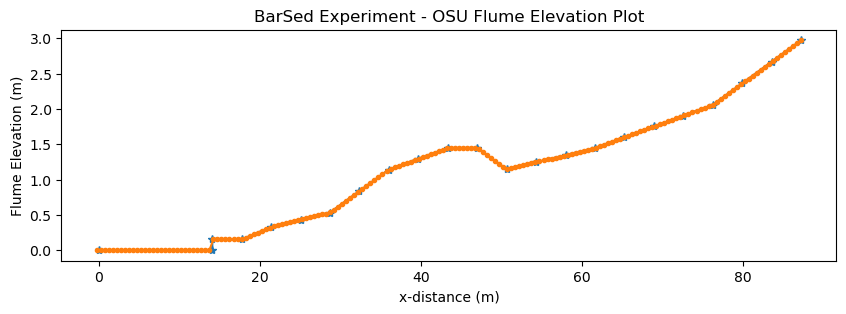

In [51]:
# Reinterpolate the raw bathymetry for the xBeach model

x = np.array(bathy_df["x_loc"])
z = np.array(bathy_df["z_loc"])

# Add the zero to the arrays
x = np.concatenate(([0.0], x))
z = np.concatenate(([0.0], z))

# x_zero = np.array(0, )
xgr, zgr = xgrid(x, z, dxmax = 0.1, dxmin = 0.5)


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 3))

# Convert axs to an array so I can iterate over it if needed
axs = np.atleast_1d(axs)

axs[0].plot(x, z    , marker = "*", label = "Bathy")
axs[0].plot(xgr, zgr, marker = ".", label = "xgr")
# axs[0].axhline(y = 3.0)
axs[0].set_xlabel("x-distance (m)")
axs[0].set_ylabel("Flume Elevation (m)")

plt.title("BarSed Experiment - OSU Flume Elevation Plot")
plt.show()
#TODO: Need to look into what the proper procedure for 


In [52]:
print(len(xgr))

176


### Generating the wave data

In [53]:
print(Run_data)

id: RUN017
Start Date: 2015-01-23
Wave Data File path: ..\..\..\BarSed_Data\WG\RUN017.mat
Num pressure gagues: None
Num advs: None


In [54]:
print(Run_data.wave_gauges[0])

Wave Gauge Type: self_calibrating
Gauge Id: 1
Location: (17.728, -1.269)


Water surface elevation: 2.448 [m]


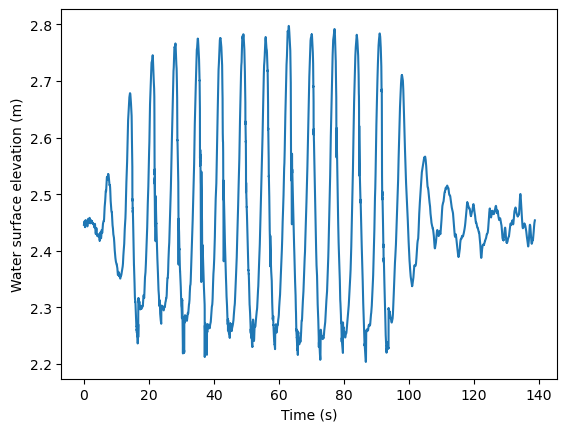

In [55]:
# Set information
zs0 =  2.448 # From Mieras et al. 2.1 Experiemental Setup

# Offset the water suface elevation from the bottom
eta = zs0 + Run_data.wave_maker.eta_wm
# Generate the wave boundary condition

# Calc the velocity of the

print(f"Water surface elevation: {zs0} [m]")
plt.plot(seconds_from_first, eta)
plt.xlabel("Time (s)")
plt.ylabel("Water surface elevation (m)")
plt.show()

### Generating the computational params for the model

In [56]:
xb_setup = XBeachModelSetup('Rand_vel_v1_1')

xb_setup.set_grid(xgr, None, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

### Wave maker boundary conditon in the x-direction for one directional flow

From Dean and Dalrymple if $S(z, t)$ is the displacement of the wave maker. Wave maker is pined at the bottom and rotates about that point. Then 

$$x = S(z, t) $$

which means a surface, $F$ can be defined with

$$F = x - S(z, t) = 0$$

using the condtion that $$ \frac{DF}{Dt} = 0 $$ where $$ \frac{D \cdot}{Dt}$$ is the material derivative. Using this relation Dean and Dalrymple derive the relation that 

$$ u - w \frac{\partial S }{ \partial z } = \frac{\partial S}{ \partial t} |_{on  x = S(z,t)}$$

Given that I don't have the $w$ velocity and I need the $u$ velocity as an input to xbeach I'm going to assume that the wave maker doesn't make that big of an angle such that 

$$\frac{\partial S}{\partial z} \approx 0$$

and that 

$$ u = \frac{\partial S }{\partial t} = \frac{d S}{d t}$$

Turns out the wave m


In [57]:
x0 = Run_data.wave_maker.position

# Calc the increment of displacement
# /delta S where S is the displacement
inc_displacement = x0[1:] - x0[:-1]

# Calc the time increment
inc_time = seconds_from_first[1:] - seconds_from_first[:-1]

# Calc the velocity = \delta S / /delta t, assuming that the slope \partial S
u = calc_velocity(x0, seconds_from_first)



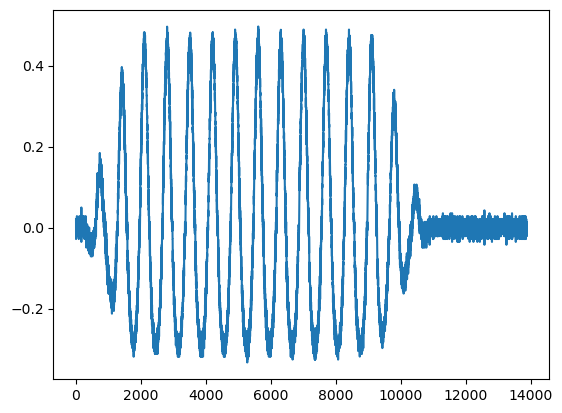

In [58]:
plt.plot(u)

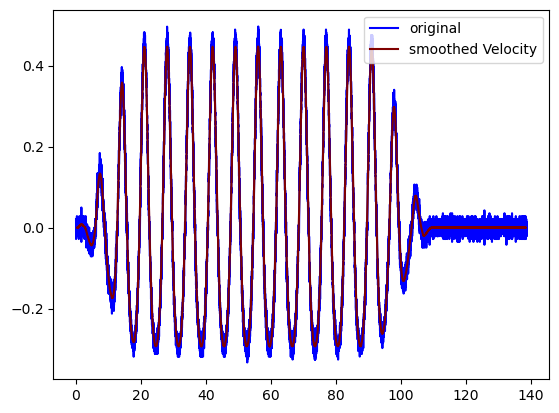

In [59]:
window_size = 75

# Get the time that corresponds to the veloctity
vel_time = seconds_from_first[1:]

smoothed_time = moving_average_filter(vel_time, window_size)
smoothed_u = moving_average_filter(u, window_size)

plt.plot(vel_time, u, color = "blue", label = "original")
plt.plot(smoothed_time, smoothed_u  , color = "maroon", label = "smoothed Velocity")
plt.legend()

In [60]:
# Need to also apply the filter to the surface pertubation 
# so that the array is the sam length as the velocity array 
smoothed_eta = moving_average_filter(eta, window_size)

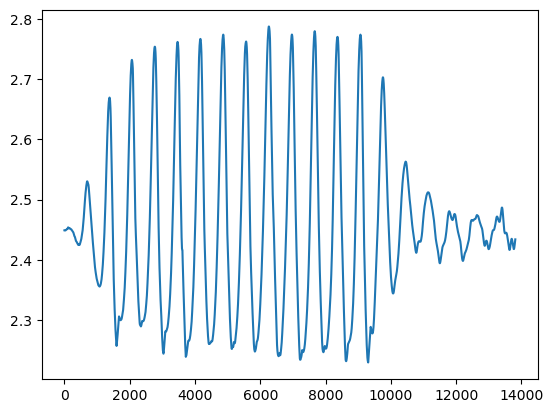

In [61]:
plt.plot(smoothed_eta)

In [62]:
# Addding a the initial values to offset from the smoothing

# Making the initial velocity zero
smoothed_u  = np.insert(smoothed_u, 0, 0.0)

# Making the initial surface elevation zs0
smoothed_eta[0] = zs0

# Make the initial time zreo
smoothed_time = np.insert(smoothed_time, 0, 0.0)

In [63]:
# Init params so that the velocity and surface pertubation can be scalled
zs_scaling = 1.0
u_scale = 1.0

# u_window = np.ones(len(u_window))

boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "scalar",
               "variable_dict": {
                   "t" : smoothed_time,
                   "zs": zs_scaling * (smoothed_eta - zs0), # Pertubation from the intial water surface
                   "U" : u_scale * smoothed_u, 
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)

tolerance = 0.01
if abs(zs_scaling - 1.0) > tolerance:
    print(f"WARNING: USING a zs scaling of {zs_scaling}. This doesn't make physical sense")

if abs(u_scale - 1.0) > tolerance:
    print(f"WARNING: USING a zs scaling of {zs_scaling}. This doesn't make physical sense")

### Manning coefficients
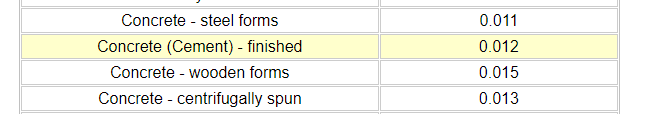

In [64]:
xb_setup.set_params({ "wbctype"     : "ts_nonh",
                    #  "taper"        : 0.0,
                     "wavemodel"    : "nonh",
                     "nonh"         : 1,
                     "CFL"          : 0.1,
                     "lateralwave"  : "neumann",
                     "zs0"          : zs0,
                     'bedfriccoef'  : 0.013, # Manning - Wood form concrete channel 
                     'taper'        : 0.0, # Spin up time of wave boundary conditons in morphological time
                    #  "order"        : 2,
                     "ARC"          : 1,
                     "front"        : "nonh_1d", "back" : "abs_1d",
                     "left"         : "wall"   , "right": "wall",
                     "tstop"        : boun_U_dict["variable_dict"]["t"].max(),
                     "outputformat" : "netcdf",
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H', "u", "v"],
})

The following params were not found in the JSON: 
{'nonh': 1}


In [65]:
xb_setup.input_par

{'par': {'nonh': 1},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh',
  'lateralwave': 'neumann',
  'taper': 0.0},
 'Physical processes': {'wavemodel': 'nonh'},
 'Model time': {'CFL': 0.1, 'tstop': 138.47999822666668},
 'Tide boundary conditions': {'zs0': 2.448},
 'Flow parameters': {'bedfriccoef': 0.013},
 'Flow boundary condition parameters': {'ARC': 1,
  'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'wall',
  'right': 'wall'},
 'Output': {'outputformat': 'netcdf',
  'tintm': 0.1,
  'tintp': 0.1,
  'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H', 'u', 'v']}}

### Generating the model files

In [66]:
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

create_directory_if_not_exists(model_dir)

exe_path = r"..\..\..\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")


Directory 'e:\BarSed_xBeach_Models\Oscillating_wave_models_nonh_multi_Runs\Run_017_nonh_dxmin_05_CFL_01_bedfric_0013\' already exists.


In [67]:
xb_setup.write_model(model_dir, num_dec_dig=10)

Data written to e:\BarSed_xBeach_Models\Oscillating_wave_models_nonh_multi_Runs\Run_017_nonh_dxmin_05_CFL_01_bedfric_0013\boun_U.bcf


In [68]:
# Write the wave maker data to a txt file

# Time, location, wse
data = {"time"     : seconds_from_first,     
        "location" : Run_data.wave_maker.position,
        "wse"      : Run_data.wave_maker.eta_wm + zs0
        }
df = pd.DataFrame(data)
display(df)
df.to_csv("wave_maker.csv", index = False)

,time,location,wse
0,0.000000,0.000176,2.446042
1,0.009998,0.000389,2.446622
2,0.020006,0.000105,2.447008
3,0.029994,0.000318,2.447523
4,0.039992,0.000318,2.448425
...,...,...,...
13881,138.810000,0.000318,2.452871
13882,138.819998,0.000389,2.453064
13883,138.829996,0.000460,2.453257
13884,138.839994,0.000460,2.453515


In [69]:
print(Run_data.wave_gauges[-1])


Wave Gauge Type: ultrasonic
Gauge Id: 17
Location: (83.385, -1.37)


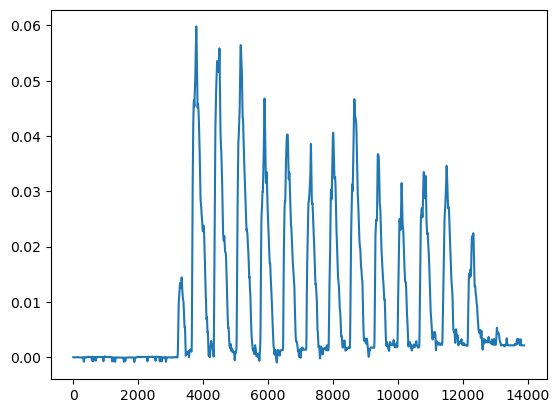

In [70]:
shore_wave_gague = Run_data.wave_gauges[-1].eta

plt.plot(shore_wave_gague)